## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$



This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


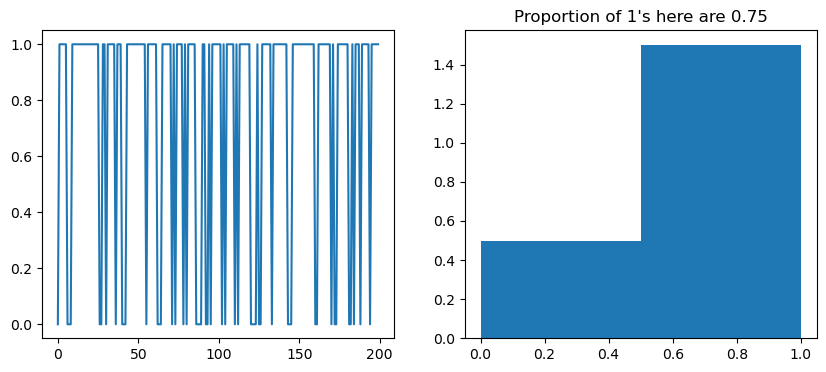

In [11]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

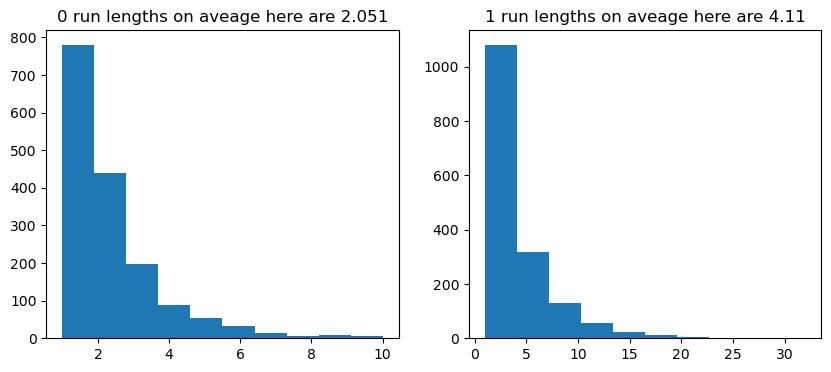

In [12]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


# Q1
# (A) Metropolis‐within‐Gibbs Specification

We have data $(\mathbf{x} = (x_1,\ldots,x_n))$ from a Normal likelihood with unknown mean $(\theta$) and unknown precision $(\tau$).  Our prior assumptions are
$$
\theta \;\sim\; \mathcal{N}\bigl(\theta_0,\;\tau_0^{-1}\bigr)
\quad\text{and}\quad
\tau \;\sim\; \Gamma(\alpha,\;\lambda).
$$
We do **not** need the individual full‐conditional forms.  Instead, we recognize the posterior is proportional to the joint:
$$
p(\theta,\tau\mid \mathbf{x})
\;\propto\;
p(\mathbf{x} \mid \theta,\tau)\;\times\;p(\theta)\;\times\;p(\tau).
$$
We will update $(\theta$) and $(\tau$) in a Gibbs‐style loop, but each update uses a **Metropolis step** (rather than a direct conjugate draw).

---

# (B) Joint Posterior (Up to Constant)

The joint (unnormalized) posterior is
$$
p(\theta,\tau\mid \mathbf{x})
\;\propto\;
\underbrace{\prod_{i=1}^n \Bigl[\mathcal{N}(x_i \mid \theta,\tau^{-1})\Bigr]}_{\text{likelihood}}
\;\times\;
\underbrace{\mathcal{N}\bigl(\theta \mid \theta_0,\;\tau_0^{-1}\bigr)}_{\text{prior on }\theta}
\;\times\;
\underbrace{\Gamma(\tau \mid \alpha,\;\lambda)}_{\text{prior on }\tau}.
$$
In practice, we only need the ratio of these expressions for the Metropolis acceptance probability, so the unknown normalization constants will cancel.

---

# (C) Metropolis‐within‐Gibbs Steps

We iterate $(t=1,\ldots,N$):

1. **Update $(\theta$)**

   1. **Propose** $(\theta^*$) from a convenient proposal 
      $$
      q\bigl(\theta^*\!\mid \theta^{(t-1)}\bigr).
      $$
      A typical choice is a Normal random walk around the old value:
      $$
      \theta^* \;\sim\;\mathcal{N}\!\Bigl(\theta^{(t-1)},\;\sigma_\theta^2\Bigr).
      $$
   2. **Compute** the Metropolis acceptance ratio:
      $$
      r_\theta
      \;=\;
      \frac{
        p(\theta^*,\,\tau^{(t-1)}\mid \mathbf{x})\;
        q\bigl(\theta^{(t-1)}\mid \theta^*\bigr)
      }{
        p\bigl(\theta^{(t-1)},\,\tau^{(t-1)}\mid \mathbf{x}\bigr)\;
        q\bigl(\theta^*\mid \theta^{(t-1)}\bigr)
      }.
      $$
      If \(q\) is **symmetric** (e.g.\ Normal), then \(q(\theta^*\mid\theta)=q(\theta\mid\theta^*)\) and that ratio cancels, leaving
      $$
      r_\theta
      =
      \frac{
        p(\theta^*,\,\tau^{(t-1)}\mid \mathbf{x})
      }{
        p(\theta^{(t-1)},\,\tau^{(t-1)}\mid \mathbf{x})
      }.
      $$
   3. **Accept/Reject** $(\theta^*$):
      $$
      \theta^{(t)} \;=\;
      \begin{cases}
      \theta^*, & \text{with prob } \min\{1,r_\theta\},\\
      \theta^{(t-1)}, & \text{otherwise}.
      \end{cases}
      $$

2. **Update $(\tau$)**

   We need $(\tau>0$).  Let $(q(\tau^*\!\mid \tau^{(t-1)})$) be a proposal **restricted to positive values** (e.g.\ a Gamma, Exponential, or log‐Normal random walk).

   1. **Propose** $(\tau^*>0$) from $(q(\tau^*\!\mid \tau^{(t-1)})$).
   2. **Compute** the Metropolis acceptance ratio:
      $$
      r_\tau
      \;=\;
      \frac{
        p\bigl(\theta^{(t)},\;\tau^*\mid \mathbf{x}\bigr)
        \;q\bigl(\tau^{(t-1)}\mid \tau^*\bigr)
      }{
        p\bigl(\theta^{(t)},\;\tau^{(t-1)}\mid \mathbf{x}\bigr)
        \;q\bigl(\tau^*\mid \tau^{(t-1)}\bigr)
      }.
      $$
      If $(q$) is symmetric on the **log scale** or is an independence sampler from the same family, the proposal ratio might simplify.
   3. **Accept/Reject** $(\tau^*$):
      $$
      \tau^{(t)} \;=\;
      \begin{cases}
      \tau^*, & \text{with prob } \min\{1,r_\tau\},\\
      \tau^{(t-1)}, & \text{otherwise}.
      \end{cases}
      $$

---

# (D) Demonstration & Comparison

1. **Implementation**: Write a loop that alternates between these two Metropolis updates.  
2. **Trace Plots**: Track the sequences $(\{\theta^{(t)}\}$) and $(\{\tau^{(t)}\}$).  
3. **Compare** to the standard **Gibbs sampler** that leverages conjugate updates (where $(\theta|\tau$) is Normal and $(\tau|\theta$) is Gamma).  
   - Even though the new algorithm uses Metropolis acceptance steps, both methods sample from the same posterior.  
   - The key difference is that the _closed‐form_ Gibbs might be more efficient because it never rejects. But Metropolis‐within‐Gibbs is more flexible for problems without handy conjugate updates.  

In conclusion, by **using the joint** in the acceptance ratio rather than sampling directly from known full‐conditional forms, we achieve a valid **Metropolis‐within‐Gibbs** sampler. This method generalizes easily to cases where the conditional distributions lack closed‐form solutions.


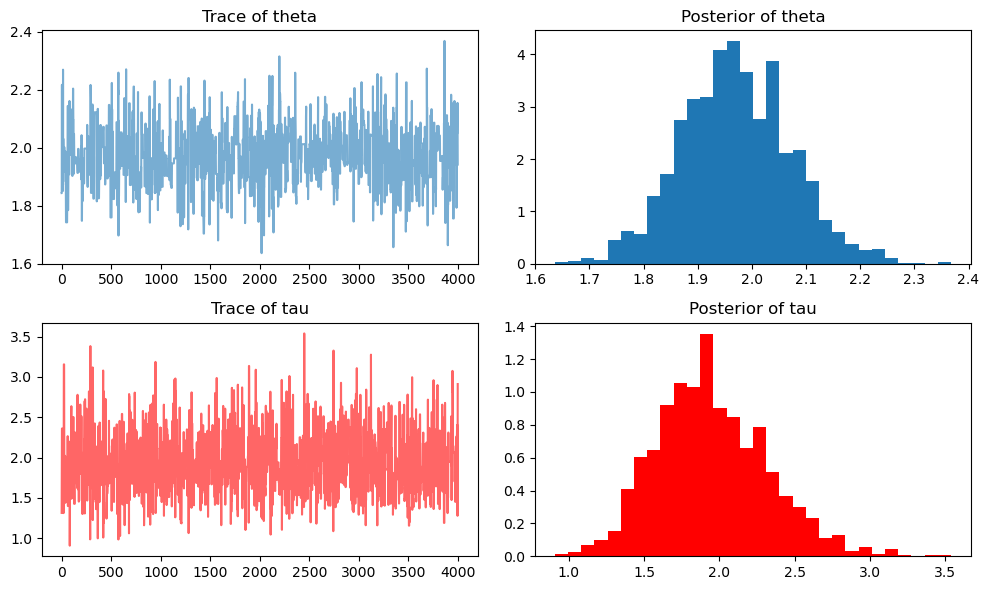

Posterior mean of theta = 1.9704070886276341
Posterior mean of tau   = 1.946403880642532


In [13]:
# Q1 Code Part
import numpy as np
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt

# 1) Generate or load data x
np.random.seed(365) # For STA 365
n = 50
true_theta = 2.0
true_tau   = 1.5
x = np.random.normal(true_theta, 1./np.sqrt(true_tau), size=n)

# 2) Prior parameters for p(theta) and p(tau)
theta_0 = 0.0
tau_0   = 0.01
alpha   = 2.0
lmbda   = 1.0

# 3) log posterior (unnormalized)
def log_posterior(theta_val, tau_val, data):
    if tau_val <= 0:
        return -np.inf
    n_data = len(data)
    # log-likelihood
    ll = -0.5 * n_data * np.log(2*np.pi*(1./tau_val)) \
         - 0.5 * tau_val * np.sum((data - theta_val)**2)
    # log-prior theta ~ Normal(theta_0, 1/tau_0)
    lp_theta = -0.5*np.log(2*np.pi*(1./tau_0)) \
               - 0.5*tau_0*(theta_val - theta_0)**2
    # log-prior tau ~ Gamma(alpha, lmbda)
    lp_tau = (alpha - 1)*np.log(tau_val) - lmbda*tau_val
    return ll + lp_theta + lp_tau

# 4) Metropolis-within-Gibbs settings
N = 5000
theta = np.zeros(N)
tau   = np.zeros(N)
theta[0] = 1.0
tau[0]   = 1.0

# Example: random-walk proposal for theta (symmetric)
proposal_sd_theta = 0.5

# Example: independence proposal for tau => Gamma(a_prop, scale=1./rate_prop)
a_prop      = 3.0
rate_prop   = 2.0  # => q(tau) = gamma(a=3, scale=0.5)

# 5) MCMC loop
for t in range(1, N):
    # A) Update theta
    current_theta = theta[t-1]
    current_tau   = tau[t-1]
    theta_prop = np.random.normal(current_theta, proposal_sd_theta)
    log_r_theta = ( log_posterior(theta_prop, current_tau, x)
                    - log_posterior(current_theta, current_tau, x) )
    # symmetric => no proposal ratio
    if np.log(np.random.rand()) < log_r_theta:
        theta[t] = theta_prop
    else:
        theta[t] = current_theta
    
    # B) Update tau (independent proposal)
    # propose from Gamma(3, scale=0.5)
    tau_prop = gamma(a=a_prop, scale=1./rate_prop).rvs()
    # q(tau_old) / q(tau_prop) => needed in acceptance ratio
    q_old = gamma(a=a_prop, scale=1./rate_prop).pdf(tau[t-1])
    q_new = gamma(a=a_prop, scale=1./rate_prop).pdf(tau_prop)
    log_r_tau = ( log_posterior(theta[t], tau_prop, x)
                  - log_posterior(theta[t], tau[t-1], x)
                  + np.log(q_old + 1e-300)
                  - np.log(q_new + 1e-300) )
    if np.log(np.random.rand()) < log_r_tau:
        tau[t] = tau_prop
    else:
        tau[t] = tau[t-1]

# 6) Show results
burn = 1000
theta_samples = theta[burn:]
tau_samples   = tau[burn:]

fig, ax = plt.subplots(2,2, figsize=(10,6))
ax[0,0].plot(theta_samples, alpha=0.6)
ax[0,0].set_title("Trace of theta")
ax[1,0].plot(tau_samples, alpha=0.6, color='red')
ax[1,0].set_title("Trace of tau")
ax[0,1].hist(theta_samples, bins=30, density=True)
ax[0,1].set_title("Posterior of theta")
ax[1,1].hist(tau_samples, bins=30, density=True, color='red')
ax[1,1].set_title("Posterior of tau")
plt.tight_layout()
plt.show()

print("Posterior mean of theta =", np.mean(theta_samples))
print("Posterior mean of tau   =", np.mean(tau_samples))



# Q2
# (A) Metropolis‐within‐Gibbs Specification

We have data $(\mathbf{x} = (x_1,\ldots,x_n)$) from a Normal likelihood with an unknown mean $(\theta$) and an unknown precision $(\tau$). However, we **no longer assume** a Normal prior for $(\theta$); instead, we take a **non‐Normal** prior. For this example, let
$$
\theta \;\sim\; \mathrm{Laplace}\bigl(\theta_0,\;b\bigr)
\quad\text{and}\quad
\tau \;\sim\; \Gamma(\alpha,\;\lambda).
$$
Then the **joint** posterior is proportional to the likelihood times these priors:
$$
p(\theta,\tau\mid \mathbf{x})
\;\propto\;
\underbrace{\prod_{i=1}^n \mathcal{N}\bigl(x_i\mid \theta,\;1/\tau\bigr)}_{\text{likelihood}}
\;\times\;
\underbrace{\mathrm{Laplace}(\theta\mid \theta_0,b)}_{\text{non‐Normal prior on }\theta}
\;\times\;
\underbrace{\Gamma(\tau\mid \alpha,\lambda)}_{\text{prior on }\tau}.
$$
We will again update $(\theta$) and $(\tau$) in a Gibbs‐style loop, but each update is a **Metropolis step** that uses the **joint** instead of an analytical full‐conditional.

---

# (B) Dependent Proposal for $(\tau$)

To enforce $(\tau>0$) and incorporate dependence on the previous $(\tau^{(t-1)}$), we use a **truncated‐normal** proposal. Specifically,
$$
\tau^*
\;\sim\;
\mathrm{TruncNorm}\!\Bigl(a=-\tfrac{\tau^{(t-1)}}{s},\;b=\infty,\;\text{loc}=\tau^{(t-1)},\;\text{scale}=s\Bigr),
$$
where \(s>0\) is some tuning parameter. This proposal is **not** symmetric and **not** independent, so in the Metropolis acceptance ratio we must include:
$$
\frac{q\bigl(\tau^{(t-1)}\mid\tau^*\bigr)}{q\bigl(\tau^*\mid\tau^{(t-1)}\bigr)}.
$$
By carefully computing the truncated‐normal PDF in both directions, we achieve a valid Metropolis update for \(\tau\).

---

# (C) Implementation Outline

1. **Update $(\theta$)** via Metropolis:
   - Propose $(\theta^*$) from a convenient, usually symmetric distribution (e.g., Normal random walk around $(\theta^{(t-1)}$)).
   - Compute 
     $$
       r_\theta 
       = 
       \frac{
         p(\theta^*,\,\tau^{(t-1)}\mid x)
       }{
         p(\theta^{(t-1)},\,\tau^{(t-1)}\mid x)
       }
     $$
     (plus any proposal‐distribution ratio if it isn’t symmetric).
   - Accept or reject $(\theta^*$) accordingly.

2. **Update $(\tau$)** via the **dependent truncated‐normal**:
   - Propose $(\tau^*>0$) from
     $(\mathrm{TruncNorm}\bigl(a,b,\text{loc}=\tau^{(t-1)},\text{scale}=s\bigr)$).
   - Compute the acceptance ratio
     $$
       r_\tau 
       = 
       \frac{
         p(\theta^{(t)},\,\tau^*\mid x)
         \;\times\;
         q(\tau^{(t-1)}\mid\tau^*)
       }{
         p(\theta^{(t)},\,\tau^{(t-1)}\mid x)
         \;\times\;
         q(\tau^*\mid\tau^{(t-1)})
       }.
     $$
   - Accept or reject $(\tau^*$) accordingly.

In this scheme, $(\theta^{(t)}$) is the updated value from step 1 before updating $(\tau$). Each iteration thus produces $(\bigl(\theta^{(t)},\,\tau^{(t)}\bigr)$).

---

# (D) Discussion: Full Conditionals Not Required

Because each Metropolis step only needs the **ratio** of the _joint_ posterior at proposed vs. old parameter values, we do **not** need to derive
$$
p\bigl(\theta\mid \tau,x\bigr)
\quad\text{nor}\quad
p\bigl(\tau\mid \theta,x\bigr)
$$
in closed form. Even though this is a “Gibbs‐like” sampler (we update $(\theta$) and $(\tau$) one at a time), we never require $(\theta\mid x,\tau$) or $(\tau\mid x,\theta$) to be integrable distributions from which we can sample directly. Instead, a **Metropolis** step is sufficient as long as we can **evaluate** the joint $(\log p(\theta,\tau\mid x)$).

Hence, **analytical full‐conditionals are not necessary** to implement this Gibbs‐style approach. This flexibility allows the use of non‐Normal priors (e.g., Laplace) and more complex proposal mechanisms (e.g., dependent truncated normals for $(\tau$) while still producing valid MCMC samples from the correct posterior.


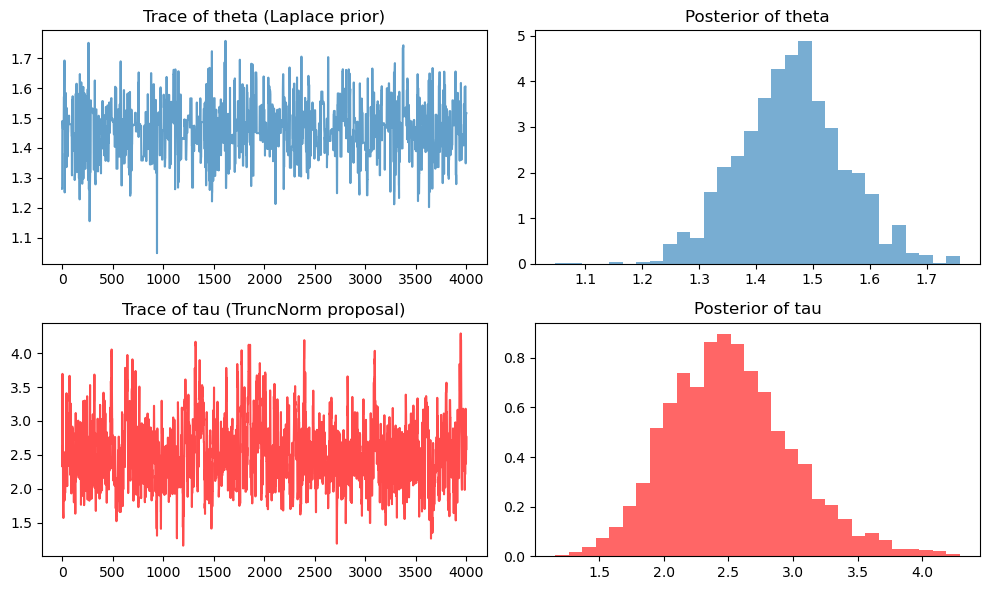

Posterior mean of theta = 1.4621948491101897
Posterior mean of tau   = 2.5185830111954974


In [15]:
# Q2 Code Part
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# -------------------------
# 1) Generate Synthetic Data
# -------------------------
np.random.seed(365) # For STA 365
n = 50
true_theta = 1.5
true_tau   = 2.0   # => variance = 1/2 = 0.5
x = np.random.normal(loc=true_theta, scale=1.0/np.sqrt(true_tau), size=n)

# -------------------------
# 2) Prior Settings
#    - Laplace for theta:  p(theta) ∝ exp(-|theta - theta0| / b)
#    - Gamma for tau:      p(tau) ∝ tau^(alpha -1) e^{-lambda tau}
# -------------------------
theta0  = 0.0    # shift in Laplace if desired
b       = 1.0    # Laplace scale
alpha   = 2.0
lmbda   = 1.0

# -------------------------
# 3) log_posterior(theta, tau)
# -------------------------
def log_posterior(theta_val, tau_val, data):
    if tau_val <= 0:
        return -np.inf
    
    # log-likelihood: Normal with mean=theta_val, precision=tau_val
    n_data = len(data)
    ll = (-0.5 * n_data * np.log(2.0*np.pi*(1.0/tau_val))
          - 0.5 * tau_val * np.sum((data - theta_val)**2))
    
    # Laplace prior on theta: p(theta) = (1/(2*b)) exp(-|theta - theta0|/b)
    # => log p(theta) = -log(2*b) - |theta - theta0|/b
    lp_theta = -np.log(2.0*b) - np.abs(theta_val - theta0)/b
    
    # Gamma prior on tau => (alpha -1)*log(tau) - lambda*tau (plus constants)
    lp_tau = (alpha - 1.0)*np.log(tau_val) - lmbda*tau_val
    
    return ll + lp_theta + lp_tau

# A helper to get truncated-normal PDF from scipy.stats:
from scipy.stats import truncnorm
def truncnorm_pdf(x, a, b, loc, scale):
    return truncnorm(a, b, loc=loc, scale=scale).pdf(x)

# -------------------------
# 4) Metropolis-within-Gibbs Setup
# -------------------------
N = 5000
theta = np.zeros(N)
tau   = np.zeros(N)

# Initial guesses
theta[0] = 0.0
tau[0]   = 1.0

# (a) Propose for theta => normal random walk (symmetric)
proposal_sd_theta = 0.5

# (b) Propose for tau => dependent truncated norm
#     tau_prop ~ TNorm(a=-tau[t-1]/s, b=∞, loc=tau[t-1], scale=s)
proposal_scale_tau = 0.4

# -------------------------
# 5) MCMC Iterations
# -------------------------
for t in range(1, N):
    # -- A) Update theta --
    old_theta = theta[t-1]
    old_tau   = tau[t-1]
    
    # propose new theta
    theta_prop = np.random.normal(loc=old_theta, scale=proposal_sd_theta)
    
    # symmetric => no proposal ratio in log_r
    log_r_theta = ( log_posterior(theta_prop, old_tau, x)
                    - log_posterior(old_theta, old_tau, x) )
    
    if np.log(np.random.rand()) < log_r_theta:
        theta[t] = theta_prop
    else:
        theta[t] = old_theta
    
    # -- B) Update tau --
    new_theta = theta[t]  # newly updated
    old_tau   = tau[t-1]
    
    # define truncated normal bounds in standard coords:
    # a_std = (lowerBound - loc)/scale
    # we want lowerBound = -old_tau / s + old_tau => that ensures positivity
    # but the question specifically said: a=-tau_(t-1)/s in standard space
    # => a_std = ( -old_tau/s - old_tau ) / proposal_scale_tau ? 
    # Typically the example is: a = -(old_tau)/proposal_scale_tau / s, etc.
    # We'll follow the statement exactly:
    a_std = -(old_tau / proposal_scale_tau)
    b_std = np.inf

    # propose tau from truncated norm
    tau_prop = truncnorm(a=a_std, b=b_std,
                         loc=old_tau,
                         scale=proposal_scale_tau).rvs()

    # forward proposal pdf = q(tau_prop | old_tau)
    q_forward_pdf = truncnorm_pdf(
        x=tau_prop,
        a=a_std,
        b=b_std,
        loc=old_tau,
        scale=proposal_scale_tau
    )
    # backward proposal pdf = q(old_tau | tau_prop)
    # => we must recalc the bounds a_std' for truncated norm centered at tau_prop
    a_std_back = -(tau_prop / proposal_scale_tau)
    q_backward_pdf = truncnorm_pdf(
        x=old_tau,
        a=a_std_back,
        b=np.inf,
        loc=tau_prop,
        scale=proposal_scale_tau
    )

    log_proposal_ratio = np.log(q_backward_pdf + 1e-300) - np.log(q_forward_pdf + 1e-300)
    log_posterior_ratio = ( log_posterior(new_theta, tau_prop, x)
                            - log_posterior(new_theta, old_tau, x) )
    
    log_r_tau = log_posterior_ratio + log_proposal_ratio

    if np.log(np.random.rand()) < log_r_tau:
        tau[t] = tau_prop
    else:
        tau[t] = old_tau

# -------------------------
# 6) Results
# -------------------------
burn_in = 1000
theta_post = theta[burn_in:]
tau_post   = tau[burn_in:]

fig, ax = plt.subplots(2,2, figsize=(10,6))

# Trace plots
ax[0,0].plot(theta_post, alpha=0.7)
ax[0,0].set_title("Trace of theta (Laplace prior)")
ax[1,0].plot(tau_post, alpha=0.7, color='red')
ax[1,0].set_title("Trace of tau (TruncNorm proposal)")

# Histograms
ax[0,1].hist(theta_post, bins=30, density=True, alpha=0.6)
ax[0,1].set_title("Posterior of theta")
ax[1,1].hist(tau_post, bins=30, density=True, alpha=0.6, color='red')
ax[1,1].set_title("Posterior of tau")

plt.tight_layout()
plt.show()

print("Posterior mean of theta =", np.mean(theta_post))
print("Posterior mean of tau   =", np.mean(tau_post))


# Q3
# (A) Metropolis‐Hastings Transition Kernel

We want to see why the **two‐state Markov chain** with transition probabilities

$$
K
\;=\;
\begin{pmatrix}
0.5 & 0.25\\[6pt]
0.5 & 0.75
\end{pmatrix}
$$

targets the **stationary distribution** $(p(0)=\tfrac{1}{3}$) and $(p(1)=\tfrac{2}{3}$).  

Recall that Metropolis–Hastings, for a current state $(x^{(t-1)}$), proposes a new state $(x^*$) from some proposal $(q\bigl(x^*\mid x^{(t-1)}\bigr)$).  It then **accepts** with probability

$$
\min\!\Bigl\{\,1,\;
\frac{\,p(x^*)\,q(x^{(t-1)}\mid x^*)\,}
     {\,p(x^{(t-1)})\,q(x^*\mid x^{(t-1)})\,}
\Bigr\},
$$

where $(p(\cdot)$) is the target (stationary) distribution.  In this specific example,

- We have **two states**: 0 and 1.  
- The target is $(p(0)=\tfrac{1}{3}$) and $(p(1)=\tfrac{2}{3}$).  
- A proposed transition from one state to the other is done with probability $(\tfrac{1}{2}$).  
- The resulting Metropolis acceptance probabilities yield the transition matrix $(K$) shown above.

Concretely, from the Metropolis–Hastings ratio we get:

- **If we are at state 0**, the proposal picks state 1 with probability $(\tfrac{1}{2}$).  The acceptance probability is
  $$
  \min\!\Bigl\{1,\;
  \tfrac{\,p(1)\,q(0\mid 1)\,}{\,p(0)\,q(1\mid 0)\,}
  \Bigr\}
  \;=\;
  \min\!\Bigl\{1,\;
  \tfrac{\,\tfrac{2}{3}\times\tfrac{1}{2}\,}{\,\tfrac{1}{3}\times\tfrac{1}{2}\,}
  \Bigr\}
  \;=\;
  \min\{1,2\}
  \;=\;
  1.
  $$
  Hence, if 0 proposes 1, it always accepts, so overall from state 0:
  - Probability $(0.5$) to **stay** at 0 (if the proposal “is 0” or “rejects”),
  - Probability $(0.5$) to **move** to 1.

- **If we are at state 1**, the proposal picks state 0 with probability $(\tfrac{1}{2}$).  The acceptance probability is
  $$
  \min\!\Bigl\{1,\;
  \tfrac{\,p(0)\,q(1\mid 0)\,}{\,p(1)\,q(0\mid 1)\,}
  \Bigr\}
  \;=\;
  \min\!\Bigl\{1,\;
  \tfrac{\,\tfrac{1}{3}\times\tfrac{1}{2}\,}{\,\tfrac{2}{3}\times\tfrac{1}{2}\,}
  \Bigr\}
  \;=\;
  \min\!\{1,\tfrac{1}{2}\}
  \;=\;
  \tfrac{1}{2}.
  $$
  So from state 1:
  - Probability $(\tfrac12\cdot \tfrac12 = 0.25$) to move to 0
  - Probability $(1 - 0.25=0.75$) to stay at 1

That derivation is exactly how we obtain

$$
K
=\;
\begin{pmatrix}
0.5 & 0.25\\
0.5 & 0.75
\end{pmatrix}.
$$

---

# (B) Interpreting the Markov Chain Behavior

1. **Stationary Distribution**  
   One can verify that $(\pi=(\tfrac{1}{3},\tfrac{2}{3})$) is indeed a stationary distribution for $(K$).  Empirically, if you run the chain for many iterations (as in the provided code), you observe that about $(\tfrac{1}{3}$) of the states are 0 and $(\tfrac{2}{3}$) of the states are 1.

2. **Run Lengths**  
   The code also measures the **average run length** of consecutive 0’s or 1’s.  Because the chain transitions from 0 to 1 half the time, on average you get about 2 consecutive 0’s (a geometric distribution with expectation 2).  From 1 to 0, you transition 25% of the time, so on average 1’s run about 4 in length (i.e., a geometric distribution with expectation 4).

---


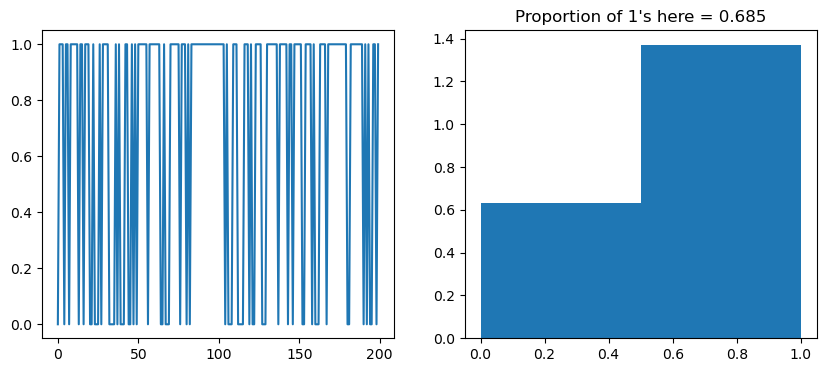

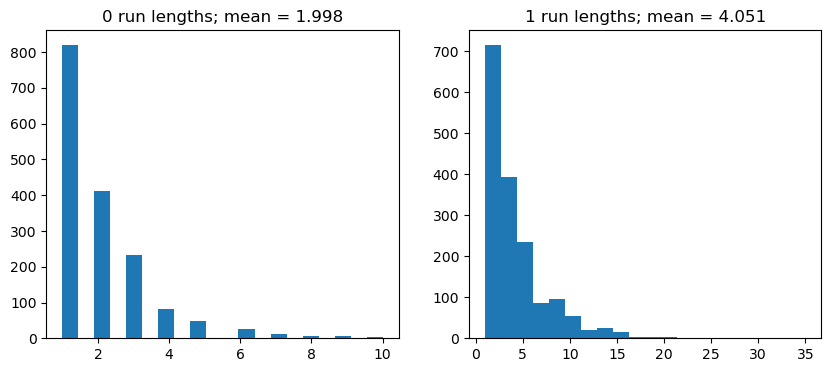

Overall proportion of 1's in the long run = 0.670


In [16]:
# Q3 Code Part
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Transition matrix K
K = np.array([[0.5, 0.25],
              [0.5, 0.75]]) 

# --- 1) Short run (T=200) ---
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    # Probability of transitioning to state 1 is K[0,1] if s_t[t-1]=0, or K[1,1] if s_t[t-1]=1
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here = {:.3f}".format(s_t.mean()))
plt.show()


# --- 2) Long run (T=10000) ---
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])

state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        # End of a run
        if s_t[t-1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length, bins=20)
ax[0].set_title("0 run lengths; mean = {:.3f}".format(np.mean(state0_run_length)))
ax[1].hist(state1_run_length, bins=20)
ax[1].set_title("1 run lengths; mean = {:.3f}".format(np.mean(state1_run_length)))
plt.show()

print("Overall proportion of 1's in the long run = {:.3f}".format(s_t.mean()))